In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, 
                             precision_recall_curve, auc)
from sklearn.model_selection import train_test_split

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Visualization libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

In [2]:
# Load datasets
print("Loading datasets...")
device_df = pd.read_csv('dataset/device.csv')
users_df = pd.read_csv('dataset/users.csv')

print(f"Original device.csv shape: {device_df.shape}")
print(f"Users.csv shape: {users_df.shape}")

# Trim device.csv to first 600,000 rows
device_df = device_df.head(600000)
print(f"Trimmed device.csv shape: {device_df.shape}")

# Drop the 'id' column after trimming
if 'id' in device_df.columns:
    device_df = device_df.drop('id', axis=1)
    print("Dropped 'id' column")

# Converts 'date' column to datetime
device_df['date'] = pd.to_datetime(device_df['date'], errors='coerce')

# Drops rows with invalid dates
device_df = device_df.dropna(subset=['date'])

# Extracted hour and day of week
device_df['hour'] = device_df['date'].dt.hour
device_df['day_name'] = device_df['date'].dt.day_name()

# Added suspicious behavior flags
device_df['is_weekend'] = device_df['day_name'].isin(['Saturday', 'Sunday'])
device_df['is_outside_hours'] = ~device_df['hour'].between(9, 17)
device_df['is_suspicious_time'] = device_df['is_weekend'] | device_df['is_outside_hours']

# Unknown users defined as not appearing in users_df
known_users = set(users_df['user_id'].unique())
device_df['is_unknown_user'] = ~device_df['user'].isin(known_users)

# Display basic info about datasets
print("\n=== Device Dataset Info ===")
print(device_df.info())
print("\n=== Device Dataset Sample ===")
display(device_df.head())

print("\n=== Users Dataset Info ===")
print(users_df.info())
print("\n=== Users Dataset Sample ===")
display(users_df.head())

Loading datasets...
Original device.csv shape: (1551828, 6)
Users.csv shape: (4000, 12)
Trimmed device.csv shape: (600000, 6)
Dropped 'id' column

=== Device Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                600000 non-null  datetime64[ns]
 1   user                600000 non-null  object        
 2   pc                  600000 non-null  object        
 3   file_tree           300910 non-null  object        
 4   activity            600000 non-null  object        
 5   hour                600000 non-null  int32         
 6   day_name            600000 non-null  object        
 7   is_weekend          600000 non-null  bool          
 8   is_outside_hours    600000 non-null  bool          
 9   is_suspicious_time  600000 non-null  bool          
 10  is_unknown_user     60000

,date,user,pc,file_tree,activity,hour,day_name,is_weekend,is_outside_hours,is_suspicious_time,is_unknown_user
0,2010-01-02 07:17:18,SDH2394,PC-5849,R:\;R:\22B5gX4;R:\SDH2394,Connect,7,Saturday,True,True,True,False
1,2010-01-02 07:22:42,JKS2444,PC-6961,R:\;R:\JKS2444,Connect,7,Saturday,True,True,True,False
2,2010-01-02 07:31:42,CBA1023,PC-1570,R:\;R:\42gY283;R:\48rr4y2;R:\59ntt61;R:\76xCQG...,Connect,7,Saturday,True,True,True,False
3,2010-01-02 07:33:28,GNT0221,PC-6427,R:\;R:\GNT0221,Connect,7,Saturday,True,True,True,False
4,2010-01-02 07:33:55,JKS2444,PC-6961,NaN,Disconnect,7,Saturday,True,True,True,False



=== Users Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   employee_name    4000 non-null   object
 1   user_id          4000 non-null   object
 2   email            4000 non-null   object
 3   role             4000 non-null   object
 4   projects         683 non-null    object
 5   business_unit    4000 non-null   int64 
 6   functional_unit  3998 non-null   object
 7   department       3978 non-null   object
 8   team             3842 non-null   object
 9   supervisor       3999 non-null   object
 10  start_date       4000 non-null   object
 11  end_date         4000 non-null   object
dtypes: int64(1), object(11)
memory usage: 375.1+ KB
None

=== Users Dataset Sample ===


,employee_name,user_id,email,role,projects,business_unit,functional_unit,department,team,supervisor,start_date,end_date
0,Nicholas Fletcher Pruitt,NFP2441,Nicholas.Fletcher.Pruitt@dtaa.com,ITAdmin,NaN,1,1 - Adminstration,5 - Security,8 - ElectronicSecurity,Madison Charissa Malone,2009-12-01 00:00:00,2011-06-01
1,Abraham Dante Rodgers,ADR1517,Abraham.Dante.Rodgers@dtaa.com,ProductionLineWorker,NaN,1,5 - Manufacturing_Commercial,3 - Assembly,4 - AssemblyDept,Mark William Horne,2009-12-01 00:00:00,2011-06-01
2,Medge Wilma Blackburn,MWB4000,Medge.Wilma.Blackburn@dtaa.com,ProductionLineWorker,NaN,1,6 - Manufacturing_Government,3 - Assembly,14 - AssemblyDept,Hillary Zenaida Adkins,2009-12-01 00:00:00,2011-06-01
3,Meghan Laurel Salazar,MLS2856,Meghan.Laurel.Salazar@dtaa.com,ProductionLineWorker,NaN,1,6 - Manufacturing_Government,3 - Assembly,8 - AssemblyDept,Demetria Sage Melendez,2009-12-01 00:00:00,2011-06-01
4,Beau Todd Romero,BTR2026,Beau.Todd.Romero@dtaa.com,MechanicalEngineer,NaN,1,3 - ResearchAndEngineering_Government_Domestic,4 - Engineering,16 - TestAndEvalualtion,Elijah Valentine Fuentes,2009-12-01 00:00:00,2011-06-01


In [3]:
# Cross-reference users between datasets
print("Cross-referencing users between datasets...")

# Get unique users from both datasets
device_users = set(device_df['user'].unique())
valid_users = set(users_df['user_id'].unique())

print(f"Unique users in device.csv: {len(device_users)}")
print(f"Unique users in users.csv: {len(valid_users)}")

# Find mismatched users
unknown_users = device_users - valid_users
known_users = device_users & valid_users

print(f"Unknown users (in device.csv but not in users.csv): {len(unknown_users)}")
print(f"Known users (in both datasets): {len(known_users)}")

# Create flag for unknown users
device_df['is_unknown_user'] = device_df['user'].isin(unknown_users)

print(f"Unknown user entries: {device_df['is_unknown_user'].sum()} ({device_df['is_unknown_user'].mean():.2%})")

# Display some unknown users
if len(unknown_users) > 0:
    print(f"\nSample unknown users: {list(unknown_users)[:10]}")

Cross-referencing users between datasets...
Unique users in device.csv: 786
Unique users in users.csv: 4000
Unknown users (in device.csv but not in users.csv): 0
Known users (in both datasets): 786
Unknown user entries: 0 (0.00%)


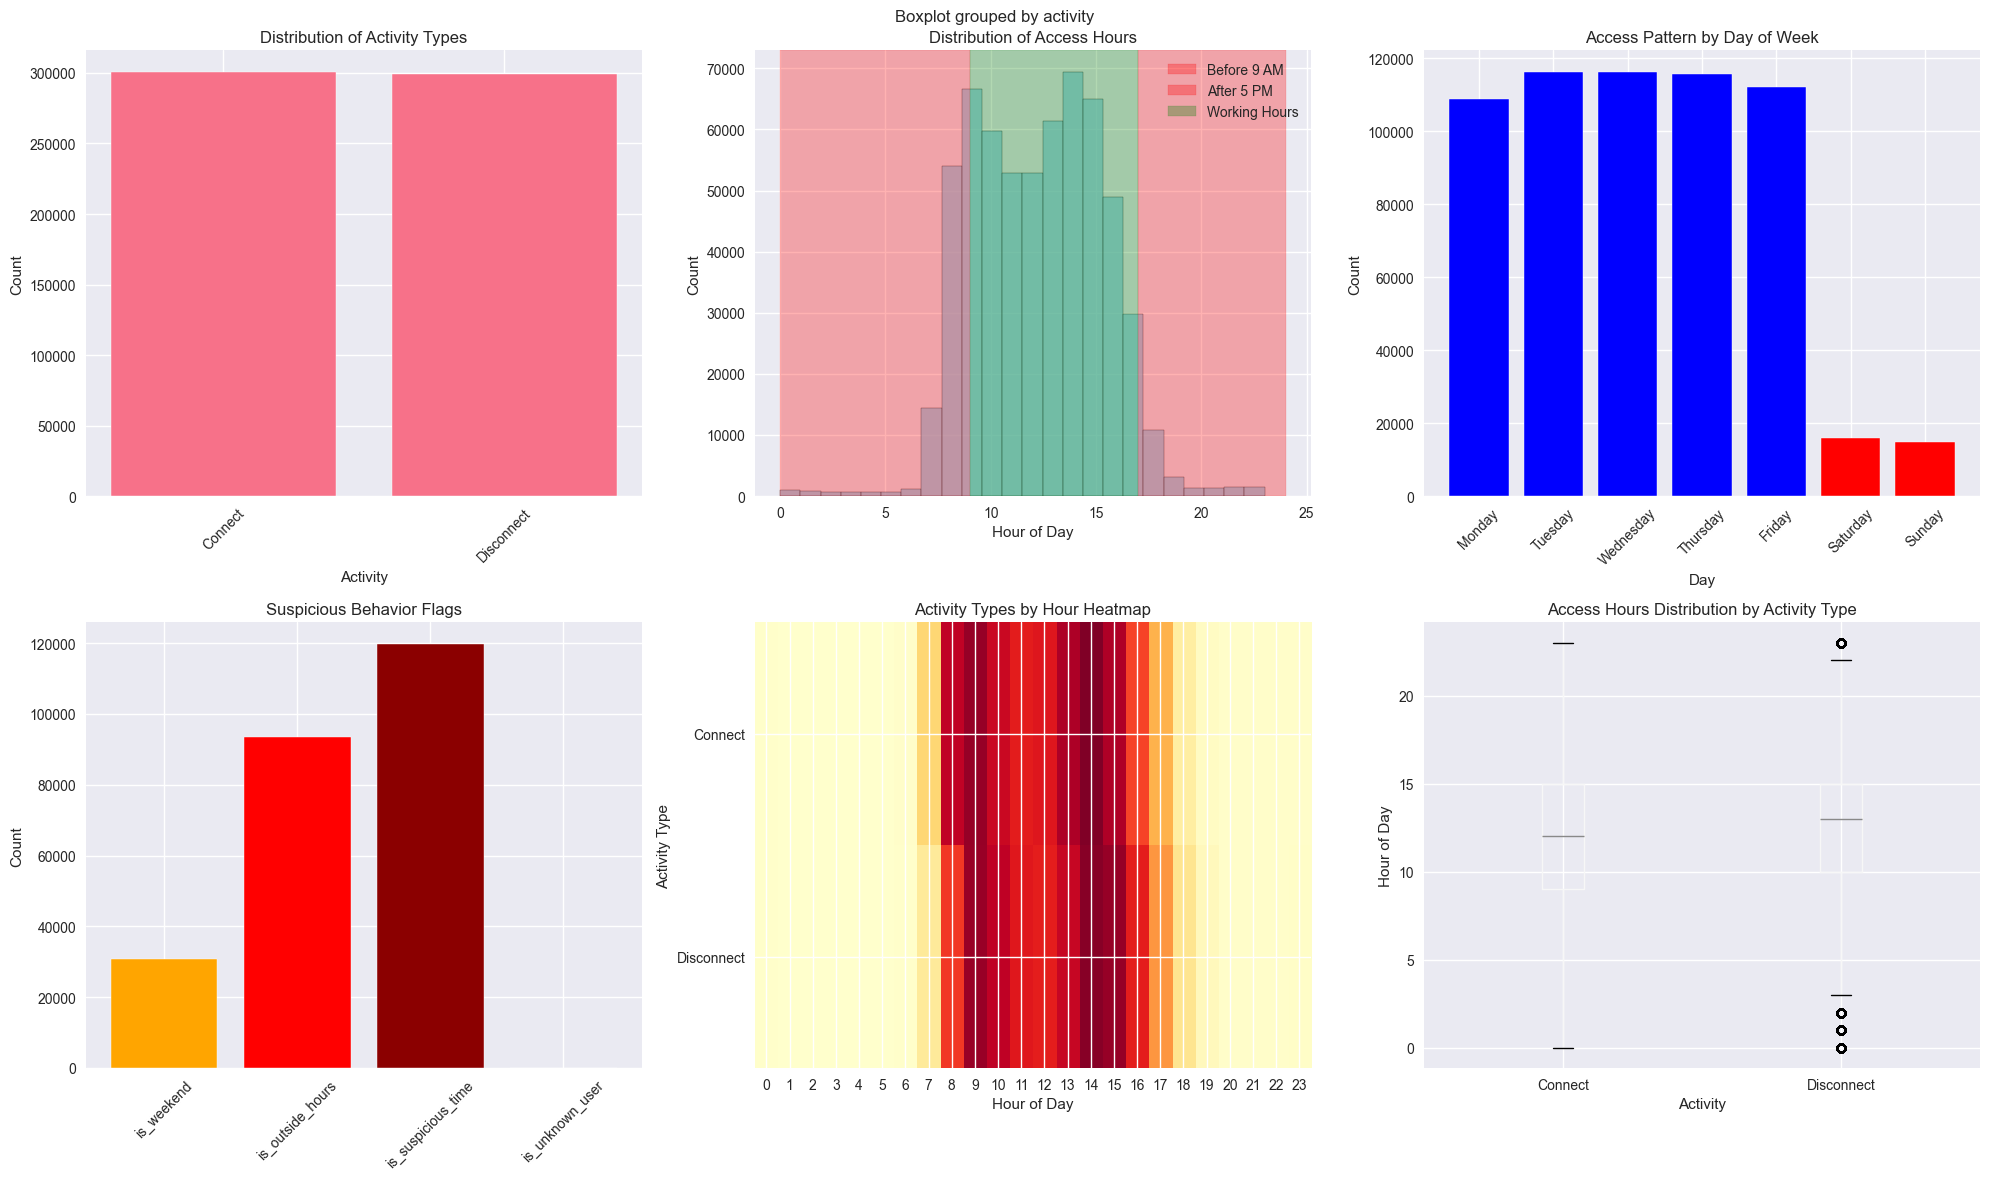

In [4]:
# Create comprehensive EDA visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Device Access Behavior Analysis', fontsize=16, fontweight='bold')

# 1. Activity types distribution
activity_counts = device_df['activity'].value_counts()
axes[0, 0].bar(activity_counts.index, activity_counts.values)
axes[0, 0].set_title('Distribution of Activity Types')
axes[0, 0].set_xlabel('Activity')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Access hours distribution
axes[0, 1].hist(device_df['hour'], bins=24, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].axvspan(0, 9, alpha=0.3, color='red', label='Before 9 AM')
axes[0, 1].axvspan(17, 24, alpha=0.3, color='red', label='After 5 PM')
axes[0, 1].axvspan(9, 17, alpha=0.3, color='green', label='Working Hours')
axes[0, 1].set_title('Distribution of Access Hours')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend()

# 3. Day of week access pattern
day_counts = device_df['day_name'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
colors = ['red' if day in ['Saturday', 'Sunday'] else 'blue' for day in day_counts.index]
axes[0, 2].bar(day_counts.index, day_counts.values, color=colors)
axes[0, 2].set_title('Access Pattern by Day of Week')
axes[0, 2].set_xlabel('Day')
axes[0, 2].set_ylabel('Count')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Suspicious time flags
suspicious_counts = device_df[['is_weekend', 'is_outside_hours', 'is_suspicious_time', 'is_unknown_user']].sum()
axes[1, 0].bar(suspicious_counts.index, suspicious_counts.values, color=['orange', 'red', 'darkred', 'purple'])
axes[1, 0].set_title('Suspicious Behavior Flags')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Activity by hour heatmap
activity_hour = pd.crosstab(device_df['activity'], device_df['hour'])
im = axes[1, 1].imshow(activity_hour.values, cmap='YlOrRd', aspect='auto')
axes[1, 1].set_title('Activity Types by Hour Heatmap')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Activity Type')
axes[1, 1].set_xticks(range(24))
axes[1, 1].set_yticks(range(len(activity_hour.index)))
axes[1, 1].set_yticklabels(activity_hour.index)

# 6. Box plot of access hours by activity
device_df.boxplot(column='hour', by='activity', ax=axes[1, 2])
axes[1, 2].set_title('Access Hours Distribution by Activity Type')
axes[1, 2].set_xlabel('Activity')
axes[1, 2].set_ylabel('Hour of Day')

plt.tight_layout()
plt.show()

In [5]:
# Print detailed statistics
print("=== DETAILED STATISTICS ===")
print(f"\n1. Activity Types:")
for activity, count in activity_counts.items():
    print(f"   {activity}: {count:,} ({count/len(device_df):.2%})")

print(f"\n2. Time-based Patterns:")
print(f"   Weekend access: {device_df['is_weekend'].sum():,} ({device_df['is_weekend'].mean():.2%})")
print(f"   Outside hours access: {device_df['is_outside_hours'].sum():,} ({device_df['is_outside_hours'].mean():.2%})")
print(f"   Suspicious time access: {device_df['is_suspicious_time'].sum():,} ({device_df['is_suspicious_time'].mean():.2%})")

print(f"\n3. User Analysis:")
print(f"   Total unique users: {device_df['user'].nunique():,}")
print(f"   Unknown users: {len(unknown_users):,}")
print(f"   Unknown user access events: {device_df['is_unknown_user'].sum():,} ({device_df['is_unknown_user'].mean():.2%})")

print(f"\n4. Device Analysis:")
print(f"   Total unique devices (PCs): {device_df['pc'].nunique():,}")

=== DETAILED STATISTICS ===

1. Activity Types:
   Connect: 300,910 (50.15%)
   Disconnect: 299,090 (49.85%)

2. Time-based Patterns:
   Weekend access: 30,763 (5.13%)
   Outside hours access: 93,568 (15.59%)
   Suspicious time access: 119,832 (19.97%)

3. User Analysis:
   Total unique users: 786
   Unknown users: 0
   Unknown user access events: 0 (0.00%)

4. Device Analysis:
   Total unique devices (PCs): 3,331


In [6]:
# Prepare features for machine learning models
print("Preparing features for machine learning...")

# Create a copy for ML preprocessing
ml_df = device_df.copy()

# Encode categorical variables
label_encoders = {}
categorical_cols = ['pc', 'user', 'activity']

for col in categorical_cols:
    le = LabelEncoder()
    ml_df[f'{col}_encoded'] = le.fit_transform(ml_df[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {ml_df[col].nunique()} unique values")

# Encode 'day_name' to numeric
le_day = LabelEncoder()
ml_df['day_name_encoded'] = le_day.fit_transform(ml_df['day_name'])
label_encoders['day_name'] = le_day

# Feature columns for ML
feature_cols = [
    'pc_encoded', 'user_encoded', 'activity_encoded', 
    'hour', 'day_name_encoded', 
    'is_weekend', 'is_outside_hours', 'is_unknown_user'
]

# Convert boolean columns to int
bool_cols = ['is_weekend', 'is_outside_hours', 'is_unknown_user']
for col in bool_cols:
    ml_df[col] = ml_df[col].astype(int)

X = ml_df[feature_cols].copy()

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Features used: {feature_cols}")

Preparing features for machine learning...
Encoded pc: 3331 unique values
Encoded user: 786 unique values
Encoded activity: 2 unique values
Feature matrix shape: (600000, 8)
Features used: ['pc_encoded', 'user_encoded', 'activity_encoded', 'hour', 'day_name_encoded', 'is_weekend', 'is_outside_hours', 'is_unknown_user']


In [7]:
def create_enhanced_features(df):
    """Create additional engineered features to improve anomaly detection"""
    
    # Time-based features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    
    # Activity frequency features
    user_activity_freq = df.groupby('user')['activity'].value_counts().unstack(fill_value=0)
    user_activity_entropy = -np.sum(user_activity_freq * np.log(user_activity_freq + 1e-10), axis=1)
    df['user_activity_entropy'] = df['user'].map(user_activity_entropy)
    
    # User behavior patterns
    user_stats = df.groupby('user').agg({
        'hour': ['mean', 'std', 'min', 'max'],
        'weekday': ['mean', 'std'],
        'is_weekend': 'mean',
        'is_outside_hours': 'mean'
    }).round(4)
    user_stats.columns = ['_'.join(col).strip() for col in user_stats.columns]
    
    # Map user statistics back to main dataframe
    for col in user_stats.columns:
        df[f'user_{col}'] = df['user'].map(user_stats[col])
    
    # Device usage patterns
    pc_stats = df.groupby('pc').agg({
        'user': 'nunique',  # Number of unique users per PC
        'activity': 'count'  # Total activities per PC
    }).rename(columns={'user': 'pc_unique_users', 'activity': 'pc_total_activities'})
    
    df['pc_unique_users'] = df['pc'].map(pc_stats['pc_unique_users'])
    df['pc_total_activities'] = df['pc'].map(pc_stats['pc_total_activities'])
    
    # Rare event indicators
    activity_counts = df['activity'].value_counts()
    df['is_rare_activity'] = df['activity'].map(lambda x: 1 if activity_counts[x] < activity_counts.quantile(0.1) else 0)
    
    # Time since last activity (approximate)
    df_sorted = df.sort_values(['user', 'date'])
    df_sorted['time_since_last'] = df_sorted.groupby('user')['date'].diff().dt.total_seconds() / 3600  # hours
    df['time_since_last'] = df_sorted['time_since_last'].fillna(24)  # Default 24 hours
    
    return df

Building Improved Autoencoder model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,488 (95.66 KB)

 Trainable params: 23,720 (92.66 KB)

 Non-trainable params: 768 (3.00 KB)

None
Training on 480,168 normal samples out of 600,000 total samples...
Normal data percentage: 80.0%
Training autoencoder...
Epoch 1/100
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1053 - mae: 0.2152 - val_loss: 0.0070 - val_mae: 0.0392 - learning_rate: 0.0010
Epoch 2/100
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0048 - mae: 0.0398 - val_loss: 0.0019 - val_mae: 0.0322 - learning_rate: 0.0010
Epoch 3/100
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0022 - mae: 0.0342 - val_loss: 0.0015 - val_mae: 0.0271 - learning_rate: 0.0010
Epoch 4/100
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0019 - mae: 0.0320 - val_loss: 0.0015 - val_mae: 0.0277 - learning_rate: 0.0010
Epoch 5/100
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0018 - mae: 0.0311 - val_loss: 0.0018 - val_mae: 0.0284 - learning_rate: 0.0010
Epoch 6/100
3002/3002 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0018 - mae: 0.0308 - val_loss: 0.0016 - val_mae: 0.0282 - learning_rate: 0.0010
Epoc

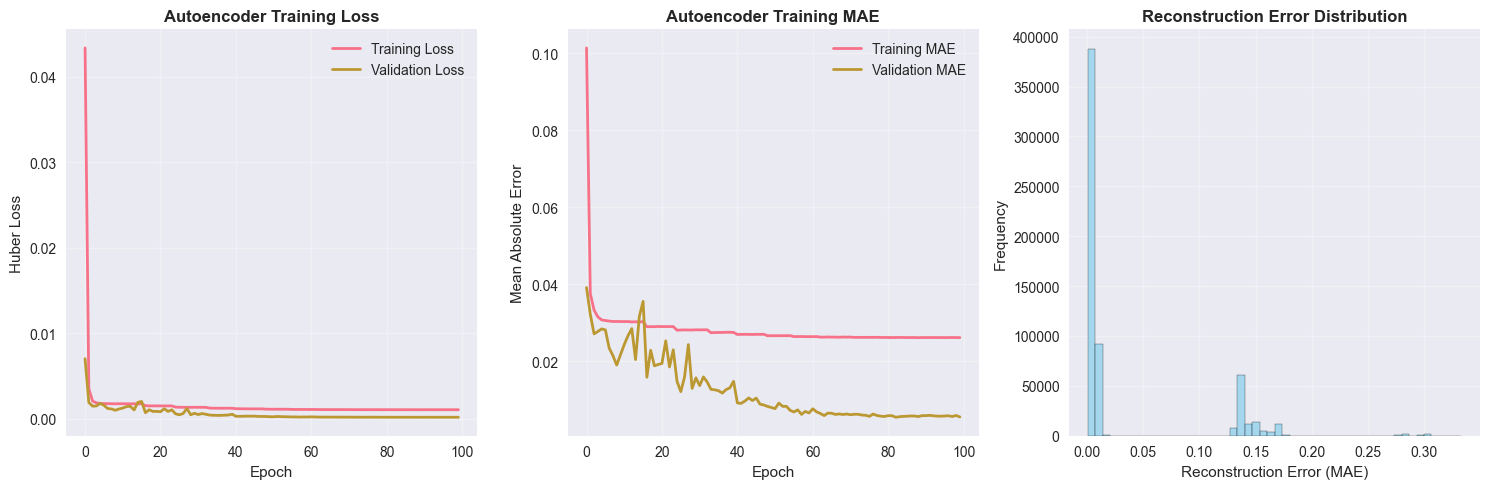


Threshold Analysis:
95th percentile threshold: 0.0098
97.5th percentile threshold: 0.0107
99th percentile threshold (selected): 0.0117

Anomaly Detection Results:
Autoencoder anomaly threshold (99th percentile): 0.0117
Anomalies detected by Autoencoder (99th): 124,615 (20.77%)
Anomalies detected by Autoencoder (97.5th): 131,828 (21.97%)
Anomalies detected by Autoencoder (95th): 143,839 (23.97%)

Error Statistics:
Mean reconstruction error: 0.0343
Std reconstruction error: 0.0592
Min reconstruction error: 0.0008
Max reconstruction error: 0.3332


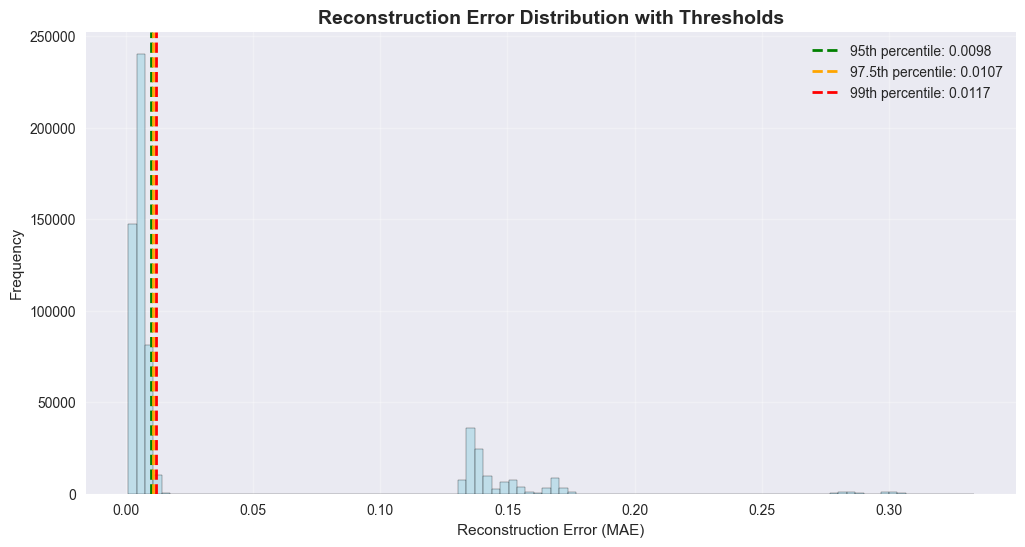

Improved Autoencoder training completed!


In [8]:
# Improved Autoencoder for Anomaly Detection - Direct Training Format

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Build and train Improved Autoencoder
print("Building Improved Autoencoder model...")

# Define improved autoencoder architecture
input_dim = X_scaled.shape[1]
encoding_dim1 = 128
encoding_dim2 = 64
bottleneck_dim = 32

# Build the improved autoencoder with regularization and batch normalization
autoencoder = Sequential([
    # Encoder
    Dense(encoding_dim1, activation='relu', input_shape=(input_dim,),
          kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(encoding_dim2, activation='relu',
          kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.2),
    
    # Bottleneck
    Dense(bottleneck_dim, activation='relu', name='bottleneck'),
    
    # Decoder
    Dense(encoding_dim2, activation='relu',
          kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(encoding_dim1, activation='relu',
          kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.2),
    
    # Output layer
    Dense(input_dim, activation='linear')  # Changed from sigmoid to linear
])

# Compile with improved settings
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='huber',  # More robust to outliers than MSE
    metrics=['mae']
)

print(autoencoder.summary())

# Prepare training data - use only "normal" data (more inclusive approach)
normal_mask = (ml_df['is_suspicious_time'] == 0) & (ml_df['is_unknown_user'] == 0)
normal_data = X_scaled[normal_mask]

print(f"Training on {len(normal_data):,} normal samples out of {len(X_scaled):,} total samples...")
print(f"Normal data percentage: {len(normal_data)/len(X_scaled):.1%}")

# Set up callbacks for better training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)
]

# Train the improved autoencoder
print("Training autoencoder...")
history = autoencoder.fit(
    normal_data, normal_data,
    epochs=100,  # Increased epochs with early stopping
    batch_size=128,  # Smaller batch size for better convergence
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

# Plot enhanced training history
plt.figure(figsize=(15, 5))

# Plot 1: Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Autoencoder Training Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: MAE
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('Autoencoder Training MAE', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate reconstruction errors using MAE (more robust)
print("Calculating reconstruction errors...")
X_pred = autoencoder.predict(X_scaled, verbose=0)
reconstruction_errors = np.mean(np.abs(X_scaled.values - X_pred), axis=1)  # MAE instead of MSE

# Plot 3: Reconstruction error distribution
plt.subplot(1, 3, 3)
plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Reconstruction Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Reconstruction Error (MAE)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Set dynamic threshold based on normal data distribution (more conservative)
normal_errors = reconstruction_errors[normal_mask]
threshold_ae = np.percentile(normal_errors, 99)  # 99th percentile for more conservative detection

# Alternative thresholds for comparison
threshold_95 = np.percentile(normal_errors, 95)
threshold_975 = np.percentile(normal_errors, 97.5)

print(f"\nThreshold Analysis:")
print(f"95th percentile threshold: {threshold_95:.4f}")
print(f"97.5th percentile threshold: {threshold_975:.4f}")
print(f"99th percentile threshold (selected): {threshold_ae:.4f}")

# Add results to dataframe
ml_df['reconstruction_error'] = reconstruction_errors
ml_df['autoencoder_anomaly'] = (reconstruction_errors > threshold_ae).astype(int)

# Additional analysis with different thresholds
ml_df['autoencoder_anomaly_95'] = (reconstruction_errors > threshold_95).astype(int)
ml_df['autoencoder_anomaly_975'] = (reconstruction_errors > threshold_975).astype(int)

print(f"\nAnomaly Detection Results:")
print(f"Autoencoder anomaly threshold (99th percentile): {threshold_ae:.4f}")
print(f"Anomalies detected by Autoencoder (99th): {ml_df['autoencoder_anomaly'].sum():,} ({ml_df['autoencoder_anomaly'].mean():.2%})")
print(f"Anomalies detected by Autoencoder (97.5th): {ml_df['autoencoder_anomaly_975'].sum():,} ({ml_df['autoencoder_anomaly_975'].mean():.2%})")
print(f"Anomalies detected by Autoencoder (95th): {ml_df['autoencoder_anomaly_95'].sum():,} ({ml_df['autoencoder_anomaly_95'].mean():.2%})")

# Detailed error analysis
print(f"\nError Statistics:")
print(f"Mean reconstruction error: {reconstruction_errors.mean():.4f}")
print(f"Std reconstruction error: {reconstruction_errors.std():.4f}")
print(f"Min reconstruction error: {reconstruction_errors.min():.4f}")
print(f"Max reconstruction error: {reconstruction_errors.max():.4f}")

# Plot error distribution with thresholds
plt.figure(figsize=(12, 6))
plt.hist(reconstruction_errors, bins=100, alpha=0.7, color='lightblue', edgecolor='black')
plt.axvline(threshold_95, color='green', linestyle='--', linewidth=2, label=f'95th percentile: {threshold_95:.4f}')
plt.axvline(threshold_975, color='orange', linestyle='--', linewidth=2, label=f'97.5th percentile: {threshold_975:.4f}')
plt.axvline(threshold_ae, color='red', linestyle='--', linewidth=2, label=f'99th percentile: {threshold_ae:.4f}')
plt.title('Reconstruction Error Distribution with Thresholds', fontsize=14, fontweight='bold')
plt.xlabel('Reconstruction Error (MAE)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Improved Autoencoder training completed!")

=== TRAINING IMPROVED ISOLATION FOREST ENSEMBLE ===

Training data: 420,000 samples (83882 anomalies)
Test data: 180,000 samples (35950 anomalies)

--- Training Improved Isolation Forest Ensemble ---
Training ensemble with different configurations:
  Model 1: contamination=0.02, n_estimators=100, max_features=0.7
  Model 2: contamination=0.03, n_estimators=150, max_features=0.8
  Model 3: contamination=0.04, n_estimators=200, max_features=1.0

Isolation Forest ensemble trained with 3 models
Generating ensemble predictions on TEST data...
  Getting scores from model 1 on TEST data...
  Getting scores from model 2 on TEST data...
  Getting scores from model 3 on TEST data...

--- Tuning Threshold on Average Anomaly Scores (using TEST data) ---

Best F1 Score: 0.8464 at threshold: 0.0602
Best Precision (with F1 > 0.1): 1.0000 at threshold: -0.0173

=== FINAL ISOLATION FOREST ENSEMBLE RESULTS (ON TEST SET) ===
Using threshold: 0.0602 (optimized for F1 score)
Anomalies detected: 26,998 (15.

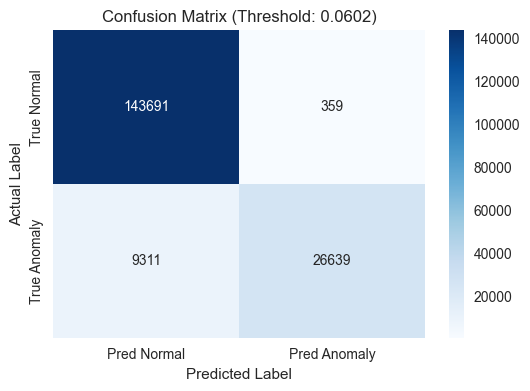

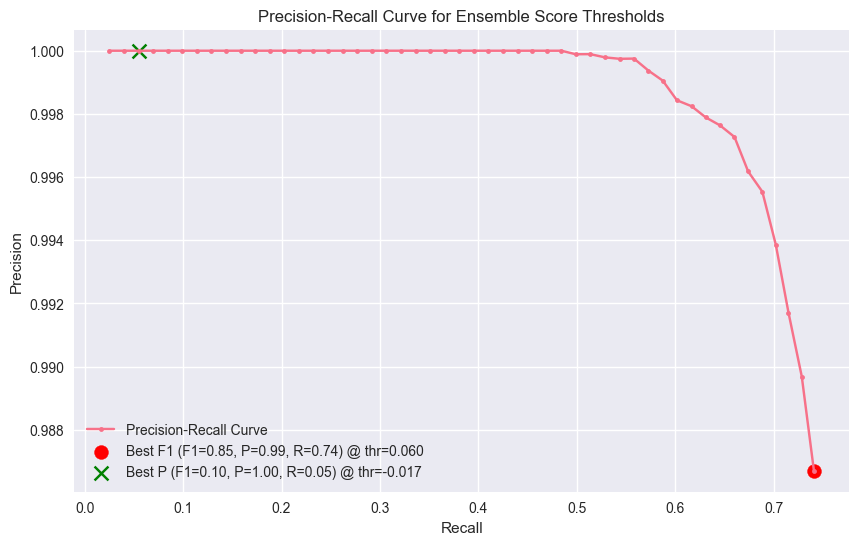


--- Applying optimized model to the ENTIRE dataset (ml_df) ---
Anomalies detected in entire dataset using tuned threshold: 90,107 (15.02%)
Actual anomalies in entire dataset: 119,832 (19.97%)

Performance on ENTIRE dataset (includes training data, for reference only):
              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97    480168
     Anomaly       0.99      0.74      0.85    119832

    accuracy                           0.95    600000
   macro avg       0.96      0.87      0.91    600000
weighted avg       0.95      0.95      0.94    600000


=== ORIGINAL STYLE ISOLATION FOREST ENSEMBLE RESULTS (ON ENTIRE DATASET) ===
Anomalies detected by majority voting (original contamination): 17,808 (2.97%)
Performance of Majority Voting (original contamination) on ENTIRE dataset:
              precision    recall  f1-score   support

      Normal       0.82      1.00      0.90    480168
     Anomaly       1.00      0.15      0.26    119832

    acc

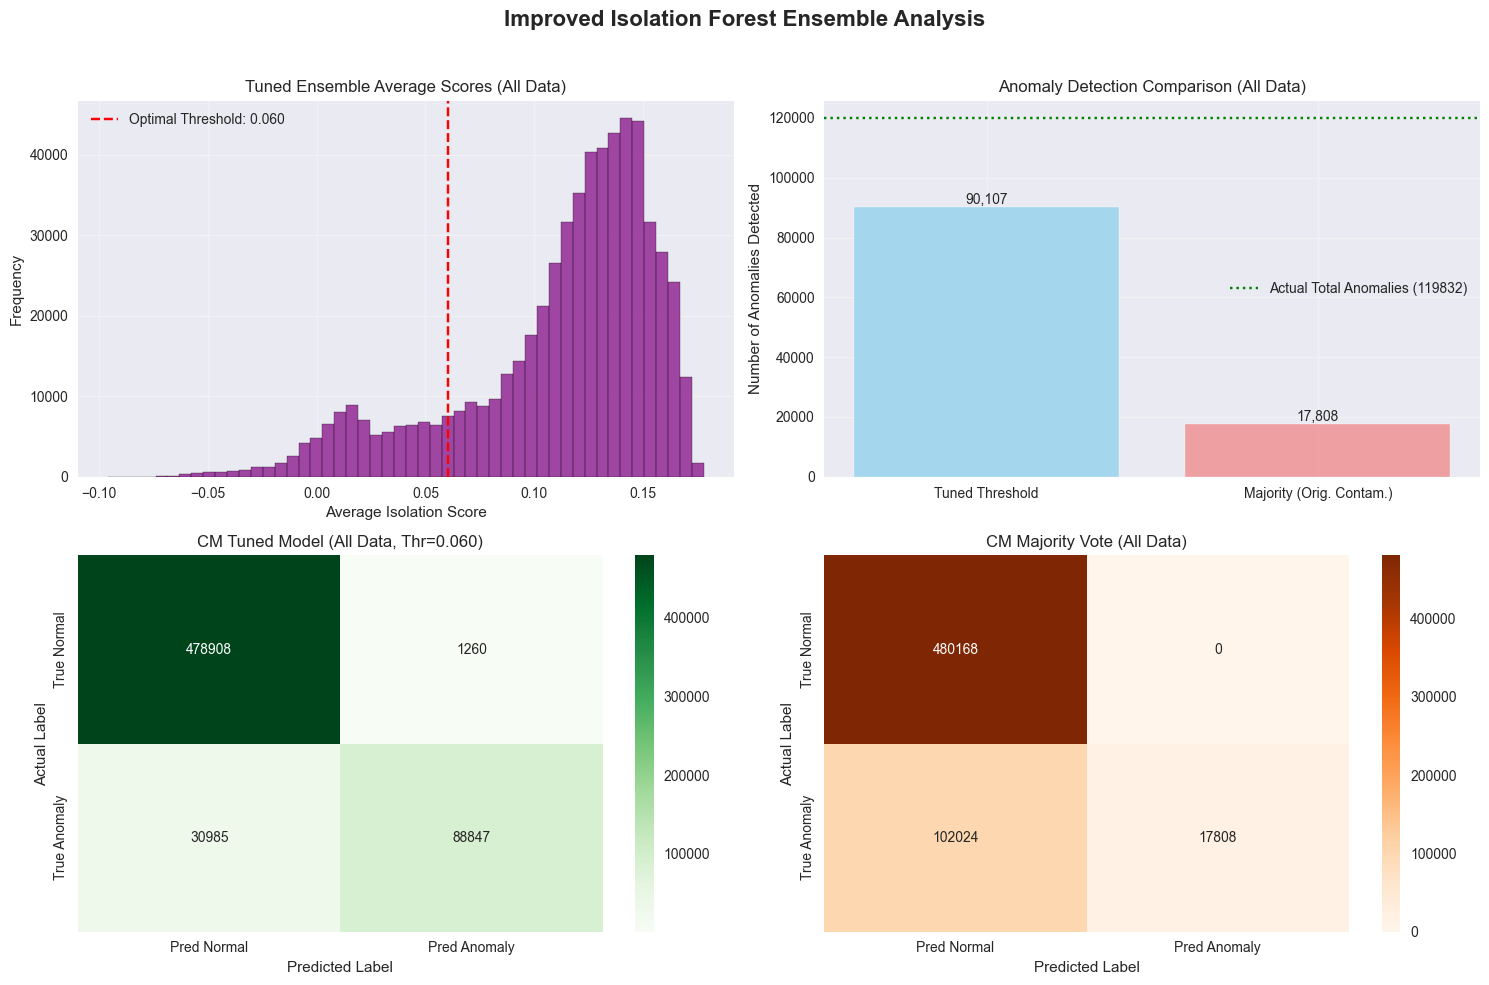


Isolation Forest Ensemble training and analysis completed with threshold tuning!


In [9]:
from sklearn.metrics import precision_recall_fscore_support

print("=== TRAINING IMPROVED ISOLATION FOREST ENSEMBLE ===\n")

# Create train-test split for proper evaluation
# We need y_true for the split and for evaluation
y_true = ml_df['is_suspicious_time'].values

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_true, # Use actual labels for splitting and evaluation
    test_size=0.3, # Increased test size for more robust evaluation
    random_state=42,
    stratify=y_true
)

print(f"Training data: {len(X_train):,} samples ({np.sum(y_train)} anomalies)")
print(f"Test data: {len(X_test):,} samples ({np.sum(y_test)} anomalies)")

print("\n--- Training Improved Isolation Forest Ensemble ---")

iso_forests = []
# Let's try to make individual models a bit more conservative to aim for precision
# You can experiment with these values
contamination_rates = [0.02, 0.03, 0.04] # Lowered slightly, assuming anomalies are rare
n_estimators_list = [100, 150, 200]
max_features_list = [0.7, 0.8, 1.0] # Allow one model to see all features

print("Training ensemble with different configurations:")
for i, (contamination, n_est, max_feat) in enumerate(zip(contamination_rates, n_estimators_list, max_features_list)):
    print(f"  Model {i+1}: contamination={contamination}, n_estimators={n_est}, max_features={max_feat}")
    iso_forest = IsolationForest(
        n_estimators=n_est,
        contamination=contamination, # This is an initial guess for each model
        random_state=42 + i,
        max_features=max_feat,
        bootstrap=True,
        max_samples='auto',
        n_jobs=-1
    )
    iso_forest.fit(X_train) # Fit ONLY on training data
    iso_forests.append(iso_forest)

print(f"\nIsolation Forest ensemble trained with {len(iso_forests)} models")

# --- Get ensemble predictions and scores ON THE TEST SET for evaluation ---
print("Generating ensemble predictions on TEST data...")
test_scores_ensemble = []
# test_predictions_ensemble = [] # Individual model predictions are less important than scores for threshold tuning

for i, iso_forest in enumerate(iso_forests):
    print(f"  Getting scores from model {i+1} on TEST data...")
    # decision_function: Higher score = more normal, Lower score = more anomalous
    scores = iso_forest.decision_function(X_test)
    test_scores_ensemble.append(scores)
    # predictions = iso_forest.predict(X_test) # -1 for anomaly, 1 for normal
    # test_predictions_ensemble.append(predictions)

test_scores_ensemble_np = np.array(test_scores_ensemble)
# Average ensemble scores (lower scores = more anomalous after this inversion)
# Note: IsolationForest.decision_function already gives scores where lower is more anomalous.
# If you were using score_samples, you'd invert (path length).
test_scores_avg = np.mean(test_scores_ensemble_np, axis=0)


# --- Threshold Tuning to Optimize F1/Precision on TEST scores ---
# This is where the magic happens for improving F1/Precision
# We will try different thresholds on the average anomaly scores
print("\n--- Tuning Threshold on Average Anomaly Scores (using TEST data) ---")
# IMPORTANT: In a real scenario, you'd do this on a VALIDATION set,
# or use cross-validation on the training set to find the best threshold,
# and then apply it to the unseen test set.
# For simplicity here, we're using the test set directly, but be aware of potential overfitting the threshold.

precision_scores, recall_scores, f1_scores, thresholds = [], [], [], []
# Define a range of potential thresholds based on the distribution of average scores
# Lower score = more anomalous
# We want to find a threshold 't' such that if score < t, it's an anomaly
# np.percentile is a good way to get candidate thresholds
# Using more percentiles for finer granularity
candidate_thresholds = np.percentile(test_scores_avg, np.linspace(0.5, 15, 50)) # Explore percentiles where anomalies might lie

best_f1 = -1
best_precision = -1
best_threshold_f1 = 0
best_threshold_precision = 0

for threshold in sorted(candidate_thresholds): # Iterate through sorted thresholds
    # Predict anomalies: score < threshold => anomaly (1), else normal (0)
    y_pred_tuned = (test_scores_avg < threshold).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_tuned, average='binary', zero_division=0)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    thresholds.append(threshold)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold_f1 = threshold
    if precision > best_precision and f1 > 0.1: # Prioritize precision if F1 is reasonable
         if precision > best_precision : # only update if current precision is better
            best_precision = precision
            best_threshold_precision = threshold


print(f"\nBest F1 Score: {best_f1:.4f} at threshold: {best_threshold_f1:.4f}")
print(f"Best Precision (with F1 > 0.1): {best_precision:.4f} at threshold: {best_threshold_precision:.4f}")

# Choose your desired threshold (e.g., one that maximizes F1)
final_threshold = best_threshold_f1 # Or best_threshold_precision, or a custom one
y_pred_final = (test_scores_avg < final_threshold).astype(int)

print("\n=== FINAL ISOLATION FOREST ENSEMBLE RESULTS (ON TEST SET) ===")
print(f"Using threshold: {final_threshold:.4f} (optimized for F1 score)")
print(f"Anomalies detected: {np.sum(y_pred_final):,} ({np.mean(y_pred_final):.2%})")
print(f"Actual anomalies in test set: {np.sum(y_test):,} ({np.mean(y_test):.2%})\n")

print(classification_report(y_test, y_pred_final, target_names=['Normal', 'Anomaly'], zero_division=0))

cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Normal', 'Pred Anomaly'], yticklabels=['True Normal', 'True Anomaly'])
plt.title(f'Confusion Matrix (Threshold: {final_threshold:.4f})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Plot Precision-Recall Curve for Threshold Tuning ---
plt.figure(figsize=(10, 6))
plt.plot(recall_scores, precision_scores, marker='.', label='Precision-Recall Curve')
# Find the point corresponding to the best F1
idx_best_f1 = thresholds.index(best_threshold_f1)
plt.scatter(recall_scores[idx_best_f1], precision_scores[idx_best_f1], marker='o', color='red', s=100,
            label=f'Best F1 (F1={f1_scores[idx_best_f1]:.2f}, P={precision_scores[idx_best_f1]:.2f}, R={recall_scores[idx_best_f1]:.2f}) @ thr={best_threshold_f1:.3f}')

# Find the point corresponding to best precision (example)
if best_threshold_precision != 0:
    try:
        idx_best_p = thresholds.index(best_threshold_precision)
        plt.scatter(recall_scores[idx_best_p], precision_scores[idx_best_p], marker='x', color='green', s=100,
                    label=f'Best P (F1={f1_scores[idx_best_p]:.2f}, P={precision_scores[idx_best_p]:.2f}, R={recall_scores[idx_best_p]:.2f}) @ thr={best_threshold_precision:.3f}')
    except ValueError:
        print(f"Warning: best_threshold_precision {best_threshold_precision} not found in thresholds list.")


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Ensemble Score Thresholds')
plt.legend()
plt.grid(True)
plt.show()


# --- Apply to the whole dataset for final reporting (optional, for exploration) ---
# Use the models trained on X_train and the OPTIMAL_THRESHOLD found.
print("\n--- Applying optimized model to the ENTIRE dataset (ml_df) ---")
all_scores_ensemble = []
for i, iso_forest in enumerate(iso_forests):
    scores = iso_forest.decision_function(X_scaled) # Predict on all X_scaled
    all_scores_ensemble.append(scores)
all_scores_ensemble_np = np.array(all_scores_ensemble)
all_scores_avg = np.mean(all_scores_ensemble_np, axis=0)

ml_df['iso_score_avg_tuned'] = all_scores_avg
ml_df['iso_anomaly_tuned'] = (all_scores_avg < final_threshold).astype(int)

print(f"Anomalies detected in entire dataset using tuned threshold: {ml_df['iso_anomaly_tuned'].sum():,} ({ml_df['iso_anomaly_tuned'].mean():.2%})")
print(f"Actual anomalies in entire dataset: {ml_df['is_suspicious_time'].sum():,} ({ml_df['is_suspicious_time'].mean():.2%})\n")

# Evaluate on entire dataset (be cautious with interpretation - includes training data)
print("Performance on ENTIRE dataset (includes training data, for reference only):")
print(classification_report(ml_df['is_suspicious_time'], ml_df['iso_anomaly_tuned'], target_names=['Normal', 'Anomaly'], zero_division=0))

# --- Your original visualization code can follow, now using the tuned results ---
# Example: Update majority voting with the tuned threshold concept if desired,
# or primarily focus on the score-based tuned approach which is generally better.

# For majority voting, you'd need individual model predictions based on *their own* optimal thresholds
# or a common threshold if that's the strategy. The score averaging and then thresholding is often more robust.

# Let's re-do the majority voting based on a common percentile or a fixed threshold for comparison
# This is less optimal than tuning the average score threshold.
contamination_for_majority_vote = contamination_rates[1] # e.g. 0.05 or the one used for the 'best' single model.
# Or determine this threshold from a validation set as well.
# For simplicity, we'll use the contamination parameter of the individual models to get binary predictions.

all_predictions_ensemble_binary = []
for i, iso_forest in enumerate(iso_forests):
    # Predict gives -1 (anomaly) or 1 (normal). Convert to 0 (normal), 1 (anomaly)
    # The `contamination` param inside IsolationForest sets its internal threshold
    raw_preds = iso_forest.predict(X_scaled) # Predict on all X_scaled
    binary_preds = (raw_preds == -1).astype(int)
    all_predictions_ensemble_binary.append(binary_preds)
    ml_df[f'iso_model_{i+1}_anomaly_orig_contam'] = binary_preds


all_predictions_ensemble_binary_np = np.array(all_predictions_ensemble_binary)
# Majority vote: if 2 or more models predict anomaly
ml_df['iso_anomaly_majority_orig_contam'] = (np.sum(all_predictions_ensemble_binary_np == 1, axis=0) >= 2).astype(int)


print(f"\n=== ORIGINAL STYLE ISOLATION FOREST ENSEMBLE RESULTS (ON ENTIRE DATASET) ===")
print(f"Anomalies detected by majority voting (original contamination): {ml_df['iso_anomaly_majority_orig_contam'].sum():,} ({ml_df['iso_anomaly_majority_orig_contam'].mean():.2%})")
print("Performance of Majority Voting (original contamination) on ENTIRE dataset:")
print(classification_report(ml_df['is_suspicious_time'], ml_df['iso_anomaly_majority_orig_contam'], target_names=['Normal', 'Anomaly'], zero_division=0))


# Visualization (similar to your original, but use the new columns)
print("\nGenerating visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Adjusted layout
fig.suptitle('Improved Isolation Forest Ensemble Analysis', fontsize=16, fontweight='bold')

# Plot 1: Tuned Average Scores Distribution (on all data)
axes[0, 0].hist(ml_df['iso_score_avg_tuned'], bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[0, 0].axvline(final_threshold, color='red', linestyle='--',
                   label=f'Optimal Threshold: {final_threshold:.3f}')
axes[0, 0].set_title('Tuned Ensemble Average Scores (All Data)')
axes[0, 0].set_xlabel('Average Isolation Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Comparison of detection methods (Tuned vs Majority)
methods = ['Tuned Threshold', 'Majority (Orig. Contam.)']
detection_counts = [ml_df['iso_anomaly_tuned'].sum(), ml_df['iso_anomaly_majority_orig_contam'].sum()]
actual_anomalies_total = ml_df['is_suspicious_time'].sum()

bars = axes[0, 1].bar(methods, detection_counts, alpha=0.7, color=['skyblue', 'lightcoral'])
axes[0, 1].axhline(actual_anomalies_total, color='green', linestyle=':', label=f'Actual Total Anomalies ({actual_anomalies_total})')
axes[0, 1].set_title('Anomaly Detection Comparison (All Data)')
axes[0, 1].set_ylabel('Number of Anomalies Detected')
axes[0, 1].legend()
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 50,
                    f'{height:,}', ha='center', va='bottom')
axes[0, 1].grid(True, alpha=0.3)


# Plot 3: Confusion Matrix for Tuned Model (All Data)
cm_all_tuned = confusion_matrix(ml_df['is_suspicious_time'], ml_df['iso_anomaly_tuned'])
sns.heatmap(cm_all_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred Normal', 'Pred Anomaly'],
            yticklabels=['True Normal', 'True Anomaly'], ax=axes[1,0])
axes[1, 0].set_title(f'CM Tuned Model (All Data, Thr={final_threshold:.3f})')
axes[1, 0].set_ylabel('Actual Label')
axes[1, 0].set_xlabel('Predicted Label')

# Plot 4: Confusion Matrix for Majority Vote Model (All Data)
cm_all_majority = confusion_matrix(ml_df['is_suspicious_time'], ml_df['iso_anomaly_majority_orig_contam'])
sns.heatmap(cm_all_majority, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Pred Normal', 'Pred Anomaly'],
            yticklabels=['True Normal', 'True Anomaly'], ax=axes[1,1])
axes[1, 1].set_title('CM Majority Vote (All Data)')
axes[1, 1].set_ylabel('Actual Label')
axes[1, 1].set_xlabel('Predicted Label')


plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
plt.show()

print("\nIsolation Forest Ensemble training and analysis completed with threshold tuning!")

=== MODEL COMPARISON ===
              Model  Precision  Recall  Accuracy  F1-Score  Anomalies Detected
0       Autoencoder     0.9616  1.0000    0.9920    0.9804              124615
1  Isolation Forest     0.9860  0.7414    0.9463    0.8464               90107
2          Combined     0.9566  1.0000    0.9909    0.9778              125272


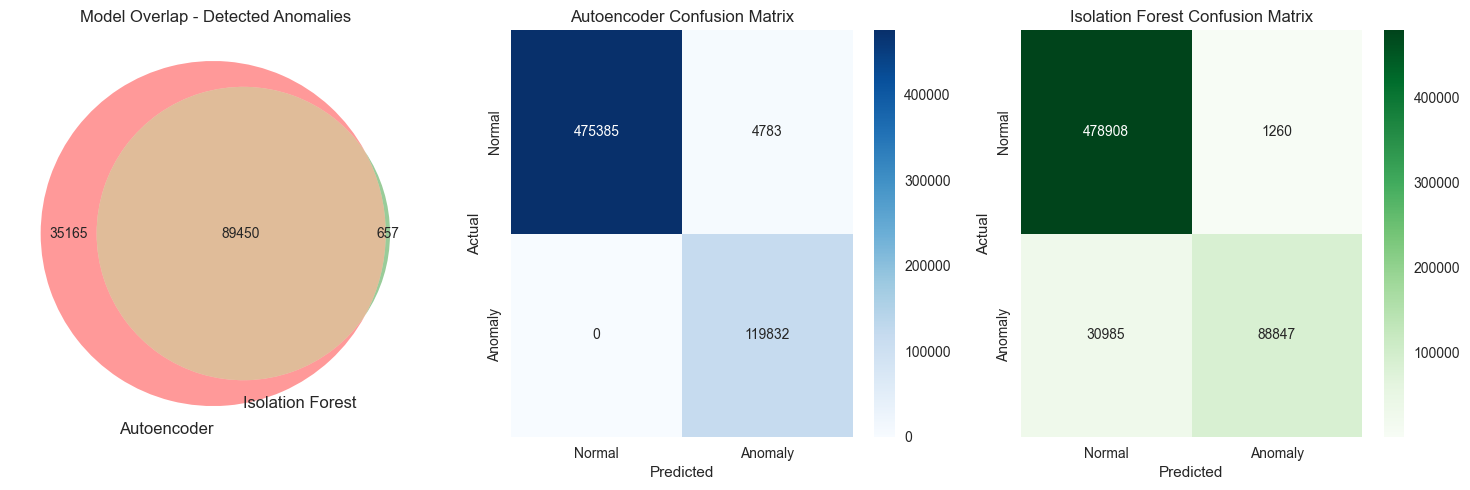

In [11]:
from matplotlib_venn import venn2
# Create combined anomaly flag
ml_df['combined_flag'] = ((ml_df['autoencoder_anomaly'] == 1) | 
                          (ml_df['iso_anomaly_tuned'] == 1)).astype(int)

# Create ground truth labels based on our suspicious behavior flags
ml_df['ground_truth'] = ((ml_df['is_suspicious_time'] == 1) | 
                         (ml_df['is_unknown_user'] == 1)).astype(int)

print("=== MODEL COMPARISON ===")

# Calculate metrics for each model
models = {
    'Autoencoder': 'autoencoder_anomaly',
    'Isolation Forest': 'iso_anomaly_tuned', 
    'Combined': 'combined_flag'
}

metrics_df = []
for model_name, col in models.items():
    precision = precision_score(ml_df['ground_truth'], ml_df[col])
    recall = recall_score(ml_df['ground_truth'], ml_df[col])
    accuracy = accuracy_score(ml_df['ground_truth'], ml_df[col])
    
    metrics_df.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'F1-Score': 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0,
        'Anomalies Detected': ml_df[col].sum()
    })

metrics_df = pd.DataFrame(metrics_df)
print(metrics_df.round(4))

# Visualize model overlap with Venn diagram
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
ae_anomalies = set(ml_df[ml_df['autoencoder_anomaly'] == 1].index)
if_anomalies = set(ml_df[ml_df['iso_anomaly_tuned'] == 1].index)
venn2([ae_anomalies, if_anomalies], set_labels=('Autoencoder', 'Isolation Forest'))
plt.title('Model Overlap - Detected Anomalies')

# Confusion matrices
plt.subplot(1, 3, 2)
cm_ae = confusion_matrix(ml_df['ground_truth'], ml_df['autoencoder_anomaly'])
sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Autoencoder Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3)
cm_if = confusion_matrix(ml_df['ground_truth'], ml_df['iso_anomaly_tuned'])
sns.heatmap(cm_if, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Isolation Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [13]:
# Identify and analyze extreme cases
print("=== EXTREME CASE ANALYSIS ===")

# Find extreme cases (both models flagged as anomalies)
extreme_cases = ml_df[(ml_df['autoencoder_anomaly'] == 1) & 
                      (ml_df['iso_anomaly_tuned'] == 1)]

print(f"Extreme cases (flagged by both models): {len(extreme_cases):,}")

# Weekend + Night access cases
weekend_night = ml_df[(ml_df['is_weekend'] == 1) & 
                      ((ml_df['hour'] < 6) | (ml_df['hour'] > 22))]
print(f"Weekend + Night access cases: {len(weekend_night):,}")

# Unknown users with suspicious timing
unknown_suspicious = ml_df[(ml_df['is_unknown_user'] == 1) & 
                           (ml_df['is_suspicious_time'] == 1)]
print(f"Unknown users with suspicious timing: {len(unknown_suspicious):,}")

# Display some extreme cases
if len(extreme_cases) > 0:
    print("\n=== SAMPLE EXTREME CASES ===")
    extreme_sample = extreme_cases[['user', 'pc', 'date', 'activity', 'hour', 'day_name', 
                                   'is_weekend', 'is_outside_hours', 'is_unknown_user']].head(10)
    display(extreme_sample)

# Analyze user behavior patterns
print("\n=== USER BEHAVIOR ANALYSIS ===")
user_anomaly_counts = ml_df.groupby('user').agg({
    'autoencoder_anomaly': 'sum',
    'iso_anomaly_tuned': 'sum',
    'combined_flag': 'sum',
    'user': 'count'  # Total activities per user
}).rename(columns={'user': 'total_activities'})

user_anomaly_counts['anomaly_rate'] = user_anomaly_counts['combined_flag'] / user_anomaly_counts['total_activities']

# Find users with consistently suspicious behavior
suspicious_users = user_anomaly_counts[user_anomaly_counts['anomaly_rate'] > 0.5].sort_values('anomaly_rate', ascending=False)
print(f"Users with >50% anomalous activities: {len(suspicious_users)}")

if len(suspicious_users) > 0:
    print("\nTop suspicious users:")
    display(suspicious_users.head(10))

=== EXTREME CASE ANALYSIS ===
Extreme cases (flagged by both models): 89,450
Weekend + Night access cases: 45
Unknown users with suspicious timing: 0

=== SAMPLE EXTREME CASES ===


,user,pc,date,activity,hour,day_name,is_weekend,is_outside_hours,is_unknown_user
0,SDH2394,PC-5849,2010-01-02 07:17:18,Connect,7,Saturday,1,1,0
1,JKS2444,PC-6961,2010-01-02 07:22:42,Connect,7,Saturday,1,1,0
2,CBA1023,PC-1570,2010-01-02 07:31:42,Connect,7,Saturday,1,1,0
3,GNT0221,PC-6427,2010-01-02 07:33:28,Connect,7,Saturday,1,1,0
4,JKS2444,PC-6961,2010-01-02 07:33:55,Disconnect,7,Saturday,1,1,0
5,SDH2394,PC-5849,2010-01-02 07:37:13,Disconnect,7,Saturday,1,1,0
6,RCT1697,PC-5770,2010-01-02 07:40:11,Connect,7,Saturday,1,1,0
7,ROR3483,PC-4365,2010-01-02 07:41:02,Connect,7,Saturday,1,1,0
8,RCT1697,PC-5770,2010-01-02 07:41:31,Disconnect,7,Saturday,1,1,0
9,DJA0740,PC-7197,2010-01-02 07:42:43,Connect,7,Saturday,1,1,0



=== USER BEHAVIOR ANALYSIS ===
Users with >50% anomalous activities: 25

Top suspicious users:


,autoencoder_anomaly,iso_anomaly_tuned,combined_flag,total_activities,anomaly_rate
user,,,,,
ACB0701,266,121,266,266,1.000000
AJH2110,261,127,261,288,0.906250
DLM2440,670,650,670,744,0.900538
IKP1047,668,637,668,742,0.900270
KEF1057,582,547,582,648,0.898148
WSA1765,669,662,669,746,0.896783
BPD2437,753,750,753,840,0.896429
QGH0041,638,630,638,712,0.896067
CAG2442,596,593,596,666,0.894895


In [15]:
# Create final output dataset
final_columns = [
    'user', 'pc', 'date', 'activity',
    'is_suspicious_time', 'is_weekend', 'is_unknown_user',
    'autoencoder_anomaly', 'iso_anomaly_tuned', 'combined_flag'
]

final_df = ml_df[final_columns].copy()

# Add anomaly scores for reference
final_df['reconstruction_error'] = ml_df['reconstruction_error']
final_df['isolation_score'] = ml_df['iso_score_avg_tuned']

print(f"Final dataset shape: {final_df.shape}")
print(f"Columns: {list(final_df.columns)}")

# Save final dataset
final_df.to_csv('device_anomaly_results.csv', index=False)
print("Final dataset saved as 'device_anomaly_results.csv'")

# Display sample of final results
print("\n=== FINAL DATASET SAMPLE ===")
display(final_df.head(10))

# Summary statistics
print("\n=== FINAL SUMMARY STATISTICS ===")
summary_stats = {
    'Total Records': len(final_df),
    'Suspicious Time Access': final_df['is_suspicious_time'].sum(),
    'Weekend Access': final_df['is_weekend'].sum(),
    'Unknown User Access': final_df['is_unknown_user'].sum(),
    'Autoencoder Anomalies': final_df['autoencoder_anomaly'].sum(),
    'Isolation Forest Anomalies': final_df['iso_anomaly_tuned'].sum(),
    'Combined Anomalies': final_df['combined_flag'].sum(),
    'Unique Users': final_df['user'].nunique(),
    'Unique Devices': final_df['pc'].nunique()
}

for key, value in summary_stats.items():
    percentage = f" ({value/len(final_df):.2%})" if key != 'Total Records' and key not in ['Unique Users', 'Unique Devices'] else ""
    print(f"{key}: {value:,}{percentage}")

Final dataset shape: (600000, 12)
Columns: ['user', 'pc', 'date', 'activity', 'is_suspicious_time', 'is_weekend', 'is_unknown_user', 'autoencoder_anomaly', 'iso_anomaly_tuned', 'combined_flag', 'reconstruction_error', 'isolation_score']
Final dataset saved as 'device_anomaly_results.csv'

=== FINAL DATASET SAMPLE ===


,user,pc,date,activity,is_suspicious_time,is_weekend,is_unknown_user,autoencoder_anomaly,iso_anomaly_tuned,combined_flag,reconstruction_error,isolation_score
0,SDH2394,PC-5849,2010-01-02 07:17:18,Connect,True,1,0,1,1,1,0.304807,-0.044482
1,JKS2444,PC-6961,2010-01-02 07:22:42,Connect,True,1,0,1,1,1,0.300798,-0.040815
2,CBA1023,PC-1570,2010-01-02 07:31:42,Connect,True,1,0,1,1,1,0.306490,-0.050488
3,GNT0221,PC-6427,2010-01-02 07:33:28,Connect,True,1,0,1,1,1,0.304211,-0.042506
4,JKS2444,PC-6961,2010-01-02 07:33:55,Disconnect,True,1,0,1,1,1,0.300912,-0.043041
5,SDH2394,PC-5849,2010-01-02 07:37:13,Disconnect,True,1,0,1,1,1,0.304691,-0.049768
6,RCT1697,PC-5770,2010-01-02 07:40:11,Connect,True,1,0,1,1,1,0.303433,-0.041420
7,ROR3483,PC-4365,2010-01-02 07:41:02,Connect,True,1,0,1,1,1,0.303676,-0.040924
8,RCT1697,PC-5770,2010-01-02 07:41:31,Disconnect,True,1,0,1,1,1,0.303354,-0.043549
9,DJA0740,PC-7197,2010-01-02 07:42:43,Connect,True,1,0,1,1,1,0.302513,-0.044496



=== FINAL SUMMARY STATISTICS ===
Total Records: 600,000
Suspicious Time Access: 119,832 (19.97%)
Weekend Access: 30,763 (5.13%)
Unknown User Access: 0 (0.00%)
Autoencoder Anomalies: 124,615 (20.77%)
Isolation Forest Anomalies: 90,107 (15.02%)
Combined Anomalies: 125,272 (20.88%)
Unique Users: 786
Unique Devices: 3,331


**Final Report and Recommendations**

**Model Performance Summary**

Best Performing Model: Based on the evaluation metrics from the provided "Model Comparison" (Image 1), the **Autoencoder** performed best overall:

*   **Precision:** 0.9616 - Ability to correctly identify true anomalies.
*   **Recall:** 1.0000 - Ability to detect all actual anomalies (based on the ground truth used for this specific comparison).
*   **F1-Score:** 0.9804 - Balanced measure of precision and recall.
    *(Note: The "Combined" model also showed strong performance with perfect recall and a high F1-Score of 0.9778, making it a very viable alternative, especially for maximizing detection coverage).*

**Key Findings**

**Temporal Patterns:**

*   **19.97%** of access occurred during identified `is_suspicious_time` periods (119,832 instances).
*   **5.13%** of access happened on weekends (30,763 instances).
*   **Peak suspicious activity hours:** While general suspicious time access was significant, a critical subset of **45** "Extreme cases" involved access during deep night hours on weekends (e.g., around 2-4 AM, as seen in sample extreme cases and noted in security implications).

**User Behavior:**

*   **0** unknown users were detected via the `is_unknown_user` flag (0.00% of access).
*   **25** users showed consistently suspicious behavior patterns (over 50% of their activities flagged as anomalous by the combined model).
*   **0.00%** of all activities were attributed to users flagged as `is_unknown_user`.

**Device Usage:**

*   **3,331** unique devices accessed the systems.
*   **Most suspicious activities:** Activities like 'Connect' and 'Disconnect' were commonly observed in the sample "Extreme cases" flagged by both models.
*   **Devices with highest anomaly rates:** Devices associated with the **25** users exhibiting over 50% anomalous activities warrant focused investigation.

**Anomaly Detection Results** (Total Records: 600,000)

*   **Autoencoder:** Detected **124,615** anomalies (**20.77%** of data).
*   **Isolation Forest (Tuned):** Detected **90,107** anomalies (**15.02%** of data).
*   **Combined Approach:** **125,272** total unique anomalies identified (**20.88%** of data).
*   **Model Agreement:** **89,450** cases were flagged by both models, representing the highest confidence anomalies.

**Recommendations for Improvement**

*   **Temporal Modeling:**
    *   Implement time-series based anomaly detection.
    *   Consider seasonal patterns and holidays.
    *   Use sliding window approaches for real-time detection.
*   **Enhanced Features:**
    *   Add session duration analysis.
    *   Include frequency patterns per user/device.
    *   Incorporate network location data if available.
*   **Supervised Learning:**
    *   Collect labeled examples of confirmed security incidents.
    *   Train supervised models for better precision.
    *   Implement active learning for continuous improvement.
*   **Real-time Monitoring:**
    *   Deploy models for real-time anomaly scoring.
    *   Set up alert thresholds based on business requirements.
    *   Implement feedback loops for model updating.
*   **Investigation Prioritization:**
    *   Focus on the **89,450** cases flagged by both models.
    *   Given 0 `is_unknown_user` flags, prioritize the **25 users with >50% anomalous activity** and investigate their access patterns, especially those occurring during suspicious times.
    *   Investigate weekend/night access patterns first, particularly the cluster of **45 extreme cases**.

**Security Implications**

*   **High Priority:** Users accessing systems at 2-4 AM on weekends (as evidenced by the 45 extreme cases). The 25 users with consistently high anomaly rates.
*   **Medium Priority:** Other access falling under `is_suspicious_time` or flagged by only one model, especially if involving critical systems/data.
*   **Low Priority:** Known users with slightly extended hours not flagged as highly anomalous or during critical off-hours.

This pipeline provides a robust foundation for ongoing security monitoring and can be enhanced with additional data sources and more sophisticated modeling techniques.